In [113]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import xarray as xr

import neuro_op as nop

In [114]:
nop.plot_setup()

In [115]:
# Define util functions


def get_name(N_nodes, nn, sd_llf):
    return str(
        "../testing/@MA1-FirstBuilder/output2/"
        + "out"
        + "-N"
        + str(N_nodes)
        + "-nn"
        + str(nn)
        + "-sd_llf"
        + str(sd_llf)
        + ".h5"
    )


def get_mu(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["mu_nodes"]


def get_sd(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["sd_nodes"]


def get_kld(a, b, c):
    data = nop.import_hdf5(get_name(a, b, c), samples=True)
    return data["kl_divs"]


# Analytical functions for conjugate pairs


def sd_N(sd0, sd_in, N):
    """Returns analytically obtained sd of Normal conjugate pair after N data points with sd=sd_in"""
    return (sd0**-2 + N * sd_in**-2) ** -0.5


def KLD_PPD(mu1, mu2, sd1, sd2):
    """Returns analytically obatined KLD of two univariate Normal distributions"""
    return np.log(sd2 / sd1) + (sd1**2 + (mu1 - mu2) ** 2) / (2 * sd2**2) - 1 / 2


def get_ls(sd_llf):
    if sd_llf == 1:
        ls = "--"
    elif sd_llf < 1:
        ls = ":"
    else:
        ls = "-"
    return ls

In [116]:
# Define parameter ranges to be used in this analysis
N_nodes = 150
N_arr = [1]
nn_arr = [0]
sd_llf_arr = np.round(np.arange(0.5, 5.1, 0.5), 1)
sd_llf_arr = sd_llf_arr[[0, 1, 3, 5, 7, 9]]
t_arr = np.arange(0, len(get_kld(N_arr[0], nn_arr[0], sd_llf_arr[-1])), 1)

In [118]:
# Initialize xarray Dataset

tmp_arr = np.empty((len(N_arr), len(nn_arr), len(sd_llf_arr), len(t_arr), N_nodes))
ds = xr.Dataset(
    {
        "mu": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
        "sd": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
        "kld": (("N", "nn", "sd_llf", "time", "node"), np.empty_like(tmp_arr)),
    },
    coords={
        "N": N_arr,
        "nn": nn_arr,
        "sd_llf": sd_llf_arr,
        "time": t_arr,
        "node": np.arange(N_nodes),
    },
)
del tmp_arr

# Populate the Dataset
for N, sd_llf in itertools.product(N_arr, sd_llf_arr):
    if N == 1:
        nn = 0
        ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_mu(
            N, nn, sd_llf
        )
        ds.sd.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_sd(
            N, nn, sd_llf
        )
        ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_kld(
            N, nn, sd_llf
        )
    elif N == 2:
        nn = 1
        ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_mu(
            N, nn, sd_llf
        )
        ds.sd.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_sd(
            N, nn, sd_llf
        )
        ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = get_kld(
            N, nn, sd_llf
        )
    else:
        for nn in nn_arr[2:]:
            ds.mu.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = (
                get_mu(N, nn, sd_llf)
            )
            ds.sd.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = (
                get_sd(N, nn, sd_llf)
            )
            ds.kld.loc[dict(N=N, nn=nn, sd_llf=sd_llf, node=np.arange(N_nodes))] = (
                get_kld(N, nn, sd_llf)
            )
ds

<xarray.Dataset> Size: 216MB
Dimensions:  (N: 1, nn: 1, sd_llf: 6, time: 10001, node: 150)
Coordinates:
  * N        (N) int64 8B 1
  * nn       (nn) int64 8B 0
  * sd_llf   (sd_llf) float64 48B 0.5 1.0 2.0 3.0 4.0 5.0
  * time     (time) int64 80kB 0 1 2 3 4 5 6 ... 9995 9996 9997 9998 9999 10000
  * node     (node) int64 1kB 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    mu       (N, nn, sd_llf, time, node) float64 72MB 0.0 0.0 ... 0.01581
    sd       (N, nn, sd_llf, time, node) float64 72MB 10.5 10.5 ... 5.05 5.05
    kld      (N, nn, sd_llf, time, node) float64 72MB 1.856 1.856 ... 1.139

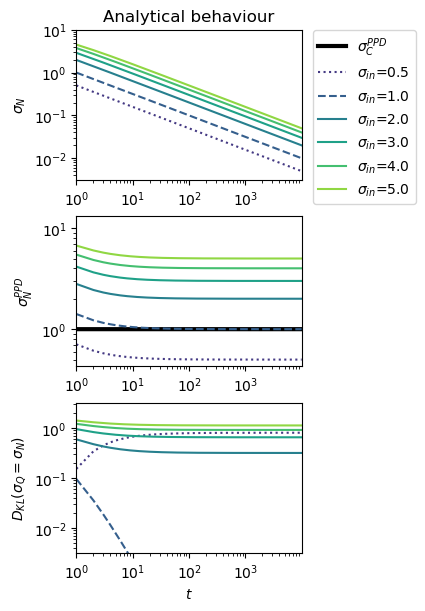

In [96]:
# How would we expect the KLD to develop, given different sd_in, sd0?

sd_arr = ds.sd_llf.values
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
N = int(10**4)  # Also, use the same time span
time = np.arange(N)

# Plotting...
x = 1
y = 3
c = 2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
ax[1].plot(time, np.ones(N) * sd_C, color="black", lw=3, label="$\sigma^{PPD}_{C}$")
colors = nop.get_colorcycle(N_colors=len(sd_arr))
for i in np.arange(3):
    ax[i].set_prop_cycle(color=colors)

for sd_in in sd_arr:
    sd = sd_N(sd0, sd_in, time)
    # sd_N(N)
    ax[0].plot(
        sd,
        ls=get_ls(sd_in),
    )

    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1].plot(
        sd_PPD,
        ls=get_ls(sd_in),
    )

    # KLD_PPD(N), given same means and sd_P=1
    ax[2].plot(
        np.log(sd_PPD / sd_C) + sd_C**2 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_{in}$=" + str(sd_in),
    )

for i in np.arange(3):
    ax[i].loglog()
    ax[i].set_xlim((time[1], time[-1]))
ax[0].set_title("Analytical behaviour")
ax[2].set_xlabel("$t$")
# ax[2].set_xlabel("No. Received Info")
ax[0].set_ylabel("$\sigma_N$")
ax[1].set_ylabel("$\sigma^{PPD}_N$")
ax[2].set_ylabel("$D_{KL}(\sigma_Q=\sigma_N)$")
ax[0].set_ylim(10**-2.5, 10**1)
ax[2].set_ylim(10**-2.5, 10**0.5)
fig.legend(bbox_to_anchor=(1, 0.97), loc="upper left")

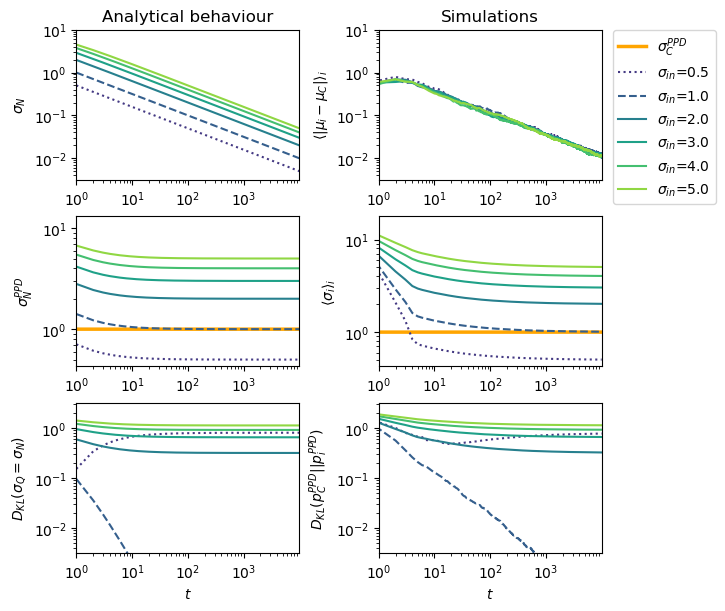

In [127]:
# Try plotting simulations next to analytics

sd_arr = ds.sd_llf.values
sd0 = 10  # For analytical results, use the same prior as for simulations
sd_C = 1  # Central node PPD's sd
N = int(10**4)  # Also, use the same time span
time = np.arange(N)

# Plotting...
x = 2
y = 3
c = 2
fig, ax = plt.subplots(y, x, figsize=(1.5 * c * x, 1 * c * y))
for i, j in itertools.product(np.arange(3), np.arange(2)):
    ax[i, j].set_prop_cycle(color=colors)
    ax[i, j].set_xlim((time[1], time[-1]))
    ax[i, j].set_xscale("log")
    ax[i, j].set_yscale("log")

# Preparation: Add line to-be-modelled PPD sd (aka. sd_PPD=1); set colorcycles
for j in [0, 1]:
    label = "$\sigma^{PPD}_{C}$"
    if j != 0:
        label = "_" + label
    ax[1, j].plot(time, np.ones(N) * sd_C, color="orange", lw=2.5, label=label)

# Plot analytical results...
j = 0
colors = nop.get_colorcycle(N_colors=len(sd_arr))

for sd_in in sd_arr:
    # sd_N(N)
    sd = sd_N(sd0, sd_in, time)
    ax[0, j].plot(
        sd,
        ls=get_ls(sd_in),
    )
    ax[0, j].set_ylabel("$\sigma_N$")

    # sd_PPD(N)
    sd_PPD = (sd**2 + sd_in**2) ** 0.5
    ax[1, j].plot(
        sd_PPD,
        ls=get_ls(sd_in),
    )
    ax[1, j].set_ylabel("$\sigma^{PPD}_N$")

    # KLD_PPD(N), given same means and sd_P=1
    ax[2, j].plot(
        np.log(sd_PPD / sd_C) + sd_C**2 / (2 * sd_PPD**2) - 1 / 2,
        ls=get_ls(sd_in),
        label="$\sigma_{in}$=" + str(sd_in),
    )
    ax[2, j].set_ylabel("$D_{KL}(\sigma_Q=\sigma_N)$")

ax[0, j].set_title("Analytical behaviour")
ax[2, j].set_xlabel("$t$")
ax[0, j].set_ylim(10**-2.5, 10**1)
ax[2, j].set_ylim(10**-2.5, 10**0.5)

# Data plots
j = 1
i = 0
for sd_llf in sd_arr:

    # <|mu_i-mu_C|>
    i = 0
    ax[i, j].plot(
        time,
        np.abs(ds.mu.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=N_range)).mean(
            dim="node",
        ),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$\langle |\mu_i-\mu_C|\\rangle_i$")

    # <sd_i>
    i = 1
    ax[i, j].plot(
        time,
        ds.sd.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=N_range).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$\langle \sigma_i\\rangle_i$")

    # <D_KL(PPD_C||PPD_i)>
    i = 2
    ax[i, j].plot(
        time,
        ds.kld.sel(N=1, nn=0, sd_llf=sd_llf, time=time, node=N_range).mean(dim="node"),
        ls=get_ls(sd_llf),
    )
    ax[i, j].set_ylabel("$D_{KL}(p^{PPD}_C||p^{PPD}_i)$")


ax[0, j].set_title("Simulations")
ax[2, j].set_xlabel("$t$")
# ax[2,j].set_xlabel("No. Received Info")
ax[0, j].set_ylim(10**-2.5, 10**1)
ax[2, j].set_ylim(10**-2.5, 10**0.5)


fig.legend(bbox_to_anchor=(1, 0.97), loc="upper left")

In [128]:
# fig.savefig("fig/@MA1-N1.pdf")